In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial import distance_matrix

In [2]:
img_name = 'monza' # Input image name
im_path = img_name + '.png' # make have to change im type

In [3]:
def get_grayscale(im_path): 
    image = cv2.imread(im_path) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

# plt.imshow(gray, cmap = 'gray')
# plt.show()

In [4]:
# Credit: https://pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

In [5]:
def sort_by_nearest_distance_fast(points):
    """Sort points by nearest distance using SciPy's distance_matrix."""
    if not points:
        return []
    
    # Convert to NumPy array for efficient computation
    points = np.array(points)
    sorted_points = [points[0]]  # Start with the first point
    points = np.delete(points, 0, axis=0)  # Remove the first point from the list

    while len(points) > 0:
        # Compute distances from the last sorted point to all remaining points
        last_point = sorted_points[-1]
        distances = np.linalg.norm(points - last_point, axis=1)
        
        # Find the index of the nearest point
        nearest_index = np.argmin(distances)
        sorted_points.append(points[nearest_index])
        
        # Remove the nearest point from the remaining points
        points = np.delete(points, nearest_index, axis=0)
    
    return np.array(sorted_points).tolist()

In [6]:
def get_edges_list(edges):
    # Inner and outer edges list
    out_edges = []
    in_edges = []
    
    # Find contours, hierarchy
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # Iterate through contours
    outer_edge_indx = -1 # 'First Parent'
    max_hier = np.max(hierarchy[:, :, -1]) # 'Youngest Child'
    
    # Find the maximum value from the final index
    for i, h in enumerate(hierarchy[0]):
        if h[3] == -1:  # Outer edge (no parent)
            if outer_edge_indx == -1:
                outer_edge_indx = i
                out_edges.append(contours[i].reshape(-1, 2).tolist())
    for i, h in enumerate(hierarchy[0]):
        if h[3] == max_hier:  # Inner edge (has a parent)
            in_edges.append(contours[i].reshape(-1, 2).tolist())

    in_edges = sort_by_nearest_distance_fast(in_edges)
    in_edges[0].append(in_edges[0][0])

    out_edges = sort_by_nearest_distance_fast(out_edges)
    out_edges[0].append(out_edges[0][0])

    return out_edges, in_edges

In [7]:
def show_edges(out_edges, in_edges):
    for i, point_list in enumerate(in_edges):
        in_x = [point[0] for point in point_list]  # Extract x-coordinates
        in_y = [-point[1] for point in point_list]  # Extract y-coordinates
    for i, point_list in enumerate(out_edges):
        out_x = [point[0] for point in point_list]  # Extract x-coordinates
        out_y = [-point[1] for point in point_list]  # Extract y-coordinates
    
    plt.plot(in_x, in_y, color='red', label = 'Inner Edge')
    plt.plot(out_x, out_y, color='blue', label = 'Outer Edge')
    plt.legend()

    plt.show()

In [8]:
def create_dictionary(out_edges, in_edges):
    # Data to be written
    name = "tfrecord-" + img_name + ".json"
    roads_dictionary = []

    # Base template for road edges
    road_edge_dict = {
             "geometry":[],
             "type": "road_edge"
             }
    
    # Base template for road line
    road_line_dict = {
             "geometry":[],
             "type": "road_line"
             }
    
    # Base Template for Object JSON
    object_dict = {
        "position":[],
        "width": None,
        "length": None,
        "heading":[],
        "velocity":[],
        "valid":[],
        "goalPosition": {
            "x": None,
            "y": None,
        },
        "type": "vehicle",
    }
    
    # ------------- ROADS ----------------------
    
    # Copies for inner and outer edges
    in_edge_dict = {
             "geometry":[],
             "type": "road_edge"
             }
    out_edge_dict = {
             "geometry":[],
             "type": "road_edge"
             }
    
    # Add outer edge points
    for out_indx in out_edges[0]:
        out_edge_dict["geometry"].append({"x": out_indx[0], "y": out_indx[1]})
    
    # Add inner edge points
    for in_indx in in_edges[0]:
        in_edge_dict["geometry"].append({"x": in_indx[0], "y": in_indx[1]})
    
    roads_dictionary.append(out_edge_dict)
    roads_dictionary.append(in_edge_dict)
    
    # ------------- POSITION ----------------------
    nearest_coords = []
    widths = []
    out_np = np.array(out_edges[0])
    in_np = np.array(in_edges[0])
    
    # Compute distances of given point on outer edge to all points on inner edge
    for coord in out_np:
        distances = np.linalg.norm(in_np - coord, axis=1)  
        nearest_index = np.argmin(distances)  # Find the index of the nearest coordinate
        nearest_coords.append(in_np[nearest_index].tolist())  # Append the nearest coordinate
        widths.append(distances[nearest_index]) # Append the nearest width
    
    min_indx = 91 # Hard-coded frame rate equivalent to Waymo Open Dataset
    
    # Position the vehicle at midpoint of track
    x_list = []
    y_list = []
    for i in range(min_indx):
        x = (out_edges[0][i][0] + nearest_coords[i][0]) / 2
        y = (out_edges[0][i][1] + nearest_coords[i][1]) / 2
        x_list.append(x)
        y_list.append(y)
        object_dict["position"].append({"x": x, "y": y})
        object_dict["valid"].append(True)
    
    # Heading
    
    # Velocity
    rate = 1
    for i in range(min_indx):
        if i != (min_indx - 1):
            vel_x = (x_list[i + 1] - x_list[i]) * rate
            vel_y = (y_list[i + 1] - y_list[i]) * rate
        else: # Ending velocity is (0, 0)
            vel_x = 0
            vel_y = 0
        object_dict["velocity"].append({"x": vel_x, "y": vel_y})
        
    # Goal position
    object_dict["goalPosition"]["x"] = x_list[min_indx - 1]
    object_dict["goalPosition"]["y"] = y_list[min_indx - 1]
    
    # Vehicle Dimensions
    track_width = np.min(widths)
    object_dict["width"] = track_width * 0.3
    object_dict["length"] = track_width * 0.6

    #------------- ROAD LINE -------------------
    # Add "optimal line" as road line, originating with midpoint of width
    opt_line = road_line_dict = {
             "geometry":[],
             "type": "road_line"
             }
    for i in range(len(out_edges[0])):
        x = (out_edges[0][i][0] + nearest_coords[i][0]) / 2
        y = (out_edges[0][i][1] + nearest_coords[i][1]) / 2
        opt_line["geometry"].append({"x": x, "y": y})
        
    roads_dictionary.append(opt_line)
    
    
    # ------------ CREATE FULL DICTIONARY ------------
    full_dictionary = {
        "name": name,
        "objects": [],
        "roads": roads_dictionary,
        "tl_states": {}
    }
    full_dictionary["objects"].append(object_dict)
    return full_dictionary, opt_line

In [9]:
def calculate_curvature(points):
    """
    Calculate curvature for a series of points along a racing line.
    """
    curvatures = []
    n = len(points)
    
    for i in range(1, n - 1):  # Exclude the first and last points
        p1 = points[i - 1]
        p2 = points[i]
        p3 = points[i + 1]
        
        # Vectors between points
        v1 = np.subtract(p2, p1)
        v2 = np.subtract(p3, p2)
        
        # Cross product (area of the parallelogram formed by v1 and v2)
        cross_product = np.abs(v1[0] * v2[1] - v1[1] * v2[0])
        
        # Lengths of vectors
        v1_length = np.linalg.norm(v1)
        v2_length = np.linalg.norm(v2)
        
        # Radius of curvature
        denominator = v1_length * v2_length * np.linalg.norm(v1 + v2)
        if denominator == 0:
            curvature = 0  # Handle straight lines
        else:
            curvature = cross_product / denominator
        
        curvatures.append(curvature)
    
    # Pad curvatures to match the number of points
    curvatures = [0] + curvatures + [0]
    return np.array(curvatures)

In [10]:
# in meters / second
#375 km / hr = 104.167
def calculate_velocity(p1, p2, curvature, max_grip=0.85, max_speed=104.167):
    # Estimate velocity based on curvature and max grip
    #print(curvature)
    radius = 1 / curvature if curvature != 0 else np.inf
    
    v_corner = np.sqrt(max_grip * radius)  # Cornering limit
    return min(v_corner, max_speed)

In [11]:
def lap_time(points, velocities):
    # Compute total lap time
    total_time = 0
    for i in range(len(points) - 1):
        dist = np.linalg.norm(points[i + 1] - points[i])
        total_time += dist / velocities[i]
    return total_time

In [12]:
def gradient_descent_racing_line(inner_edge, outer_edge, init_line, max_iters=100, alpha=0.01):
    #print(init_line["geometry"])
    init_line_list = []
    for item in init_line["geometry"]:
        point = (item['x'], item['y'])
        init_line_list.append(point)

    line = np.copy(init_line_list)
    for _ in range(max_iters):
        gradients = np.zeros_like(line)
        velocities = []

        # Compute velocities and lap time for the current line
        for i in range(len(line) - 1):
            # Estimate curvature, velocity
            curvature = calculate_curvature(init_line_list)  # Calculate curvature at point i
            velocities.append(calculate_velocity(line[i], line[i+1], curvature[i], max_grip=9.8, max_speed=300))

        # Compute lap time
        lap_time_current = lap_time(line, velocities)

        # Compute gradient for each point
        for i in range(1, len(line) - 1):  # Skip start and end points
            line_plus_dx = np.copy(line)
            line_plus_dx[i, 0] += 1e-5
            lap_time_dx = lap_time(line_plus_dx, velocities)

            line_plus_dy = np.copy(line)
            line_plus_dy[i, 1] += 1e-5
            lap_time_dy = lap_time(line_plus_dy, velocities)

            gradients[i, 0] = (lap_time_dx - lap_time_current) / 1e-5
            gradients[i, 1] = (lap_time_dy - lap_time_current) / 1e-5

        # Update points
        line -= alpha * gradients

        out_np = np.array(outer_edge[0])
        in_np = np.array(inner_edge[0])
        
        # Enforce track boundary constraints
        for i in range(len(line)):
            near_distances = np.linalg.norm(in_np - line[i], axis=1)  
            far_distances = np.linalg.norm(out_np - line[i], axis=1)
            nn_index = np.argmin(near_distances)
            nf_index = np.argmin(far_distances)
            line[i] = np.clip(line[i], inner_edge[0][nn_index], outer_edge[0][nf_index])

    return line

In [13]:
def calculate_opt_line(out_edges, in_edges, init_line):
    opt_line = gradient_descent_racing_line(in_edges, out_edges, init_line)
    print(opt_line)
    return opt_line
    #opt_line["geometry"].append({"x": x, "y": y})
    #pass

In [14]:
# Calculating an optimal line using gradient descent
def calc_opt_line(out_edges, in_edges, name):
    lr = 1e-2
    max_velocity = 374.977 # km / h (approximated)
    
    sim_track_length = 0
    actual_track_length = 0 # in meters
    scale = 0
    __, opt_line = create_dictionary(out_edges, in_edges)

    # Find simulated track length
    opt_line = list(opt_line["geometry"])
    for i in range(1, len(opt_line)):
        current_point = np.array((opt_line[i]["x"], opt_line[i]["y"]))
        prev_point = np.array((opt_line[i-1]["x"], opt_line[i-1]["y"]))
        sim_track_length += np.linalg.norm(current_point - prev_point)

    # Find corresponding real track length from text database
    with open('/home/ar3015/IW/gpudrive/F1_23_tracks/circuit_lengths.txt') as circuit_lengths:
        for line in circuit_lengths:
            if line.lower().find(name.lower()) != -1:
                actual_track_length = float(line.split()[-2]) * 1000 # km to m
    
    # Scale real track to sim track
    scale = actual_track_length / sim_track_length

    print(name)
    print(sim_track_length)
    print(actual_track_length)
    

In [15]:
def serialize(full_dictionary, name):
    # Serializing json
    json_object = json.dumps(full_dictionary, indent=4)
    
    # Specify the folder path and file name
    folder_path = "/home/ar3015/IW/gpudrive/data/processed/f1_opt/"
    file_path = os.path.join(folder_path, "tfrecord-" + name + ".json")
    
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    # Writing to sample.json
    with open(file_path, "w") as outfile:
        outfile.write(json_object)

In [16]:
def update_line(dictionary, line):
    opt_line = road_line_dict = {
             "geometry":[],
             "type": "road_line"
             }

    for i in range(len(line)):
        x = line[i][0]
        y = line[i][1]
        opt_line["geometry"].append({"x": x, "y": y})
    
    if dictionary["roads"][0].get("type") == "road_line": 
        dictionary["roads"].update(new_line)
    return dictionary

In [17]:
# Put all functions together
def create_json(im_path, name):
    print("Serialized ", im_path)
    gray = get_grayscale(im_path)
    edges = auto_canny(gray)
    out_edges, in_edges = get_edges_list(edges)
    show_edges(out_edges, in_edges)
    full_dictionary, opt_line = create_dictionary(out_edges, in_edges)
    opt_line = calculate_opt_line(out_edges, in_edges, opt_line)
    full_dictionary = update_line(full_dictionary, opt_line)
    serialize(full_dictionary, name)

Serialized  /home/ar3015/IW/gpudrive/F1_23_tracks/australia.jpeg


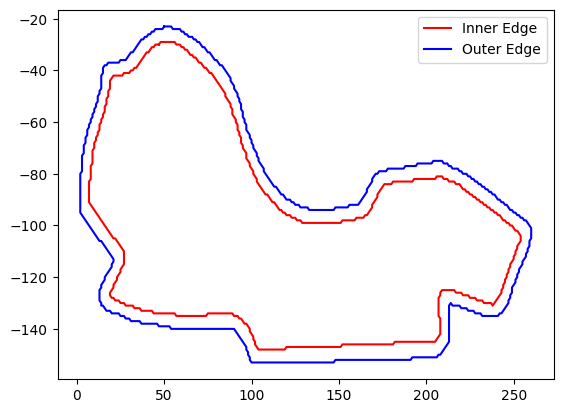

[[49. 24.]
 [49. 24.]
 [48. 24.]
 ...
 [52. 23.]
 [49. 24.]
 [49. 24.]]
Serialized  /home/ar3015/IW/gpudrive/F1_23_tracks/bahrain.png


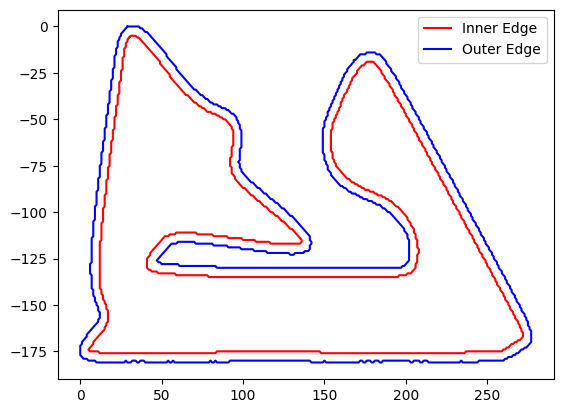

[[55.         96.        ]
 [55.         96.        ]
 [55.         96.        ]
 ...
 [56.49998425 96.        ]
 [55.         96.        ]
 [55.         96.        ]]
Serialized  /home/ar3015/IW/gpudrive/F1_23_tracks/qatar.png


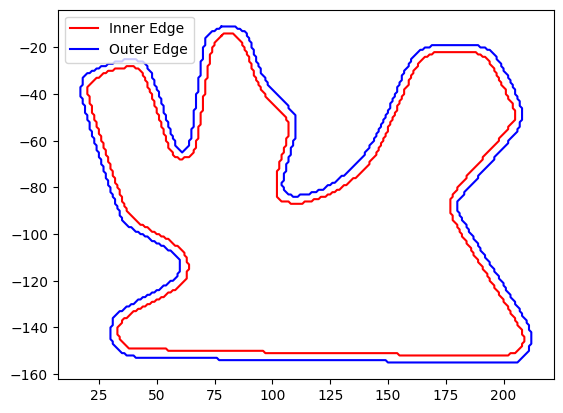

[[78. 11.]
 [77. 12.]
 [77. 12.]
 ...
 [80. 11.]
 [79. 11.]
 [78. 11.]]
Serialized  /home/ar3015/IW/gpudrive/F1_23_tracks/austria.png


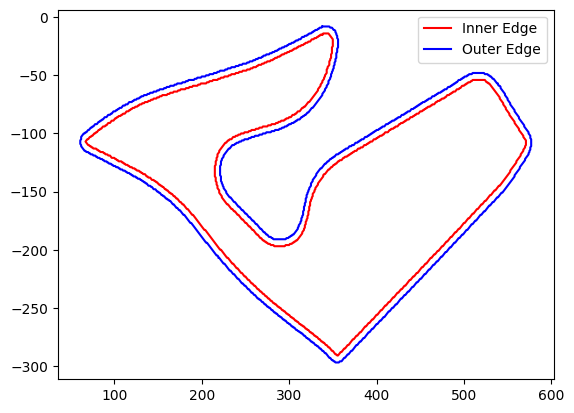

[[337.   9.]
 [337.   9.]
 [337.   9.]
 ...
 [340.   8.]
 [337.   9.]
 [337.   9.]]
Serialized  /home/ar3015/IW/gpudrive/F1_23_tracks/azerbaijan.png


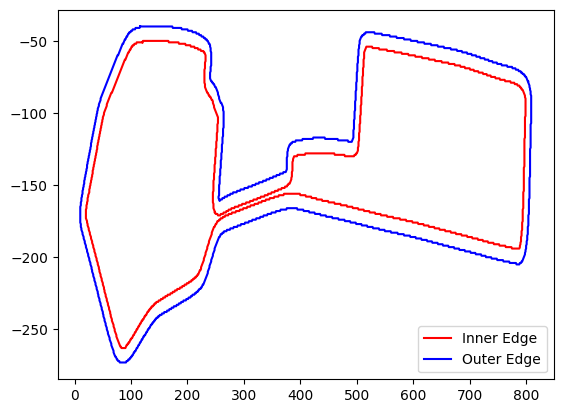

In [ ]:
import torch
device = torch.device("cuda")## if torch.cuda.is_available() else "cpu")
directory = "/home/ar3015/IW/gpudrive/F1_23_tracks/"
for filename in os.listdir(directory):
    name = filename.split(".")[0]
    path = os.path.join(directory, filename)
    if os.path.isfile(path):
        create_json(path, name)